# Figure 4: Fooof cannot characterize oscillation peaks that are not clearly separable

In [1]:
import warnings
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import yaml
from fooof import FOOOF
from fooof.sim.gen import gen_aperiodic
from scipy.signal import sawtooth

from utils import elec_phys_signal

%load_ext autoreload
%autoreload 2


def fooof_fit(psd: np.array, cond: str, freq: np.array,
              freq_range: tuple, fooof_params: dict) -> tuple:
    """
    Return aperiodic fit and corresponding label.

    Parameters
    ----------
    psd : np.array
        Power spectral density.
    cond : str
        Condition.
    freq : np.array
        Freq array for PSD.
    freq_range : tuple of int
        Fitting range.
    fooof_params : dict
        Fooof parameters.

    Returns
    -------
    tuple(ndarray, str)
        (aperiodic fit, plot label).
    """
    fm = FOOOF(**fooof_params)
    fm.fit(freq, psd, freq_range)
    exp = fm.get_params("aperiodic", "exponent")
    label = fr"$\beta_{{{cond}}}$={exp:.2f}"
    ap_fit = gen_aperiodic(freq, fm.aperiodic_params_)
    return 10**ap_fit, label


#### Load params and make directory

In [3]:
yaml_file = open('params.yml')
parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)
globals().update(parsed_yaml_file)

Path(fig_path).mkdir(parents=True, exist_ok=True)

#### Load empirical data of dataset 2 and calc PSD before, during, and after the seizure

In [4]:
# EEG Params
sample_rate = 256
cha_nm = "F3-C3"

data_path = "../data/Fig4+7/"
seiz_data = np.load(data_path + cha_nm + ".npy", allow_pickle=True)

# Seizure sample timepoints
seiz_start_samples = 87800
seiz_end_samples = 91150
seiz_len_samples = seiz_end_samples - seiz_start_samples

# Select seizure time points
full_seiz = slice(seiz_start_samples - seiz_len_samples,
                  seiz_end_samples + seiz_len_samples)
pre_seiz = slice(seiz_start_samples - seiz_len_samples,
                 seiz_start_samples)
seiz = slice(seiz_start_samples, seiz_end_samples)
post_seiz = slice(seiz_end_samples, seiz_end_samples + seiz_len_samples)

data_full = seiz_data[full_seiz]
time_full = np.linspace(0, data_full.size/sample_rate, num=data_full.size)
data_pre = seiz_data[pre_seiz]
data_seiz = seiz_data[seiz]
data_post = seiz_data[post_seiz]

# Welch Params
nperseg = sample_rate
welch_params = {"fs": sample_rate, "nperseg": nperseg}

# Calc psd pre, post, seiz
freq, psd_EEG_pre = sig.welch(data_pre, **welch_params)
freq, psd_EEG_seiz = sig.welch(data_seiz, **welch_params)
freq, psd_EEG_post = sig.welch(data_post, **welch_params)

#### Simulate sawtooth signal of same duration as empirical seizure

In [5]:
# Sawtooth Signal
saw_power = 0.02
saw_width = 0.69
freq_saw = 3  # Hz
time_seiz = np.linspace(0, data_seiz.size/sample_rate, num=data_seiz.size)

saw = sawtooth(2 * np.pi * freq_saw * time_seiz, width=saw_width)
saw *= saw_power  # scaling

# make signal 10 seconds zero, 10 seconds strong, 10 seconds zero
saw_full = np.r_[np.zeros(seiz_len_samples),
                 saw,
                 np.zeros(seiz_len_samples)]

# Create 1/f noise and add
exponent = 1.8
seed = 2
duration = time_full[-1] + 2/sample_rate  # two time units lost during Fourier
aperiodic, _ = elec_phys_signal(exponent, sample_rate=sample_rate,
                                duration=duration, seed=seed, highpass=True)
full_saw = aperiodic + saw_full

# normalize
full_saw = (full_saw - full_saw.mean()) / full_saw.std()

# Calc PSDs saw
saw_pre = full_saw[:seiz_len_samples]
saw_seiz = full_saw[seiz_len_samples:2*seiz_len_samples]
saw_post = full_saw[2*seiz_len_samples:]

freq, psd_saw_pre = sig.welch(saw_pre, **welch_params)
freq, psd_saw_seiz = sig.welch(saw_seiz, **welch_params)
freq, psd_saw_post = sig.welch(saw_post, **welch_params)

#### Fit fooof before, during, and after the seizure

In [6]:
warnings.filterwarnings("ignore")

# Fooof params: standard
fooof_params = dict(verbose=False)

# Calc fooof pre-, post-, and during seizure
freq_range = [1, 100]
calc_fooof = dict(freq=freq, freq_range=freq_range, fooof_params=fooof_params)

fit_pre_eeg, lab_pre_eeg = fooof_fit(psd_EEG_pre, "pre ", **calc_fooof)
fit_seiz_eeg, lab_seiz_eeg = fooof_fit(psd_EEG_seiz, "seiz", **calc_fooof)
fit_post_eeg, lab_post_eeg = fooof_fit(psd_EEG_post, "post", **calc_fooof)

fit_pre_sim, lab_pre_saw = fooof_fit(psd_saw_pre, "pre ", **calc_fooof)
fit_seiz_sim, lab_seiz_saw = fooof_fit(psd_saw_seiz, "seiz", **calc_fooof)
fit_post_sim, lab_post_saw = fooof_fit(psd_saw_post, "post", **calc_fooof)

#### Plot settings

In [7]:
# mpl settings
mpl.rcParams['xtick.labelsize'] = legend_fontsize
mpl.rcParams['ytick.labelsize'] = legend_fontsize
mpl.rcParams['axes.labelsize'] = legend_fontsize
mpl.rcParams['legend.fontsize'] = legend_fontsize
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

# Tick params
ticks_time = dict(length=6, width=1.5)
ticks_psd = dict(length=4, width=1)
panel_labels = dict(x=0, y=1.02, fontsize=panel_fontsize,
                    fontdict=dict(fontweight="bold"))

# a1 EEG Time Series
yticks_a1 = [-250, 0, 200]
yticklabels_a1 = [-250, "", 200]
xlim_a1 = (0, time_full[-1])
ylabel_a1 = fr"{cha_nm} [$\mu$V]"
ymin = -250
ylim_a1 = (ymin, 200)
axes_a1 = dict(yticks=yticks_a1, yticklabels=yticklabels_a1, xlim=xlim_a1,
               ylim=ylim_a1)

# a2 EEG PSD
xticks_a2 = [1, 10, 100]
xticklabels_a2 = []
yticks_a2 = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
yticklabels_a2 = [r"$10^{-2}$", "", "", "", "", "", "", r"$10^5$"]
ylim_a2 = (yticks_a2[0], yticks_a2[-1])
xlim_a2 = freq_range
ylabel_a2 = r"PSD [$\mu$$V^2$/Hz]"
xlabel_a2 = ""
axes_a2 = dict(xticks=xticks_a2, xticklabels=xticklabels_a2,
               yticks=yticks_a2, yticklabels=yticklabels_a2, ylim=ylim_a2,
               xlim=xlim_a2, xlabel=xlabel_a2,
               ylabel=ylabel_a2)

# b1 Saw tooth Time Series
y_max = np.abs(full_saw).max() * 1.1
yticks_b = (-3.5, 0, 3.5)
yticklabels_b = (-3.5, "", 3.5)
xlim_b = (0, time_full[-1])
ylim_b = (yticks_b[0], yticks_b[-1])
xlabel_b = "Time [s]"
ylabel_b = "Simulation [a.u.]"

axes_b = dict(yticks=yticks_b, yticklabels=yticklabels_b,
              xlim=xlim_b, ylim=ylim_b, xlabel=xlabel_b)

# b2 Saw tooth PSD
yticks_b2 = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
yticklabels_b2 = [r"$10^{-6}$", "", "", "", "", "", "", "", r"$10^2$"]
ylim_b2 = (yticks_b2[0], yticks_b2[-1])
xlabel_b2 = "Frequency [Hz]"
ylabel_b2 = "PSD [a.u.]"
axes_b2 = dict(xticks=xticks_a2, xticklabels=xticks_a2, yticks=yticks_b2,
               yticklabels=yticklabels_b2, ylim=ylim_b2,
               xlim=xlim_a2, xlabel=xlabel_b2)

# Rectangles to mark pre, seizure, post
rect_height = np.abs(data_full).max() * 2
rect = dict(height=rect_height, alpha=0.2)

start_pre = 0
start_seiz = seiz_len_samples / sample_rate
start_post = 2*seiz_len_samples / sample_rate

xy_pre = (start_pre, ymin)
xy_seiz = (start_seiz, ymin)
xy_post = (start_post, ymin)

width = seiz_len_samples / sample_rate

# Add colored rectangles
rect_EEG_pre_params = dict(xy=xy_pre, width=width, color=c_pre, **rect)
rect_EEG_seiz_params = dict(xy=xy_seiz, width=width, color=c_seiz, **rect)
rect_EEG_post_params = dict(xy=xy_post, width=width, color=c_post, **rect)

# Figure 4

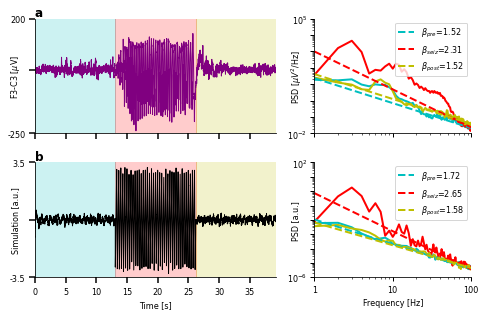

In [8]:
fig, axes = plt.subplots(2, 2, figsize=[fig_width, 4.5], sharex="col",
                         gridspec_kw=dict(width_ratios=[1, .65]))

# a1 Plot EEG seizure
ax = axes[0, 0]
ax.plot(time_full, data_full, c=c_real, lw=1)

# Set rectangles
rect_EEG_pre = plt.Rectangle(**rect_EEG_pre_params)
rect_EEG_seiz = plt.Rectangle(**rect_EEG_seiz_params)
rect_EEG_post = plt.Rectangle(**rect_EEG_post_params)
ax.add_patch(rect_EEG_pre)
ax.add_patch(rect_EEG_seiz)
ax.add_patch(rect_EEG_post)

# Set axes
ax.set(**axes_a1)
ax.set_ylabel(ylabel_a1, labelpad=-15)
ax.tick_params(**ticks_time)
ax.text(s="a", **panel_labels, transform=ax.transAxes)

# a2 Plot EEG PSD
ax = axes[0, 1]
ax.loglog(freq, psd_EEG_pre, c_pre, lw=2)
ax.loglog(freq, psd_EEG_seiz, c_seiz, lw=2)
ax.loglog(freq, psd_EEG_post, c_post, lw=2)

# Plot EEG fooof fit
ax.loglog(freq, fit_pre_eeg, "--", c=c_pre, lw=2, label=lab_pre_eeg)
ax.loglog(freq, fit_seiz_eeg, "--", c=c_seiz, lw=2, label=lab_seiz_eeg)
ax.loglog(freq, fit_post_eeg, "--", c=c_post, lw=2, label=lab_post_eeg)

# Set axes
ax.set(**axes_a2)
ax.legend()
ax.set_ylabel(ylabel_a2, labelpad=-17)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=10)
ax.yaxis.set_minor_locator(y_minor)
ax.tick_params(**ticks_psd)

# b1 Sawtooth Time Series
ax = axes[1, 0]
ax.plot(time_full, full_saw, c=c_sim, lw=1)

# Set rectangles
rect_saw_pre = plt.Rectangle(**rect_EEG_pre_params)
rect_saw_seiz = plt.Rectangle(**rect_EEG_seiz_params)
rect_saw_post = plt.Rectangle(**rect_EEG_post_params)
ax.add_patch(rect_saw_pre)
ax.add_patch(rect_saw_seiz)
ax.add_patch(rect_saw_post)

# Set axes
ax.set(**axes_b)
ax.set_ylabel(ylabel_b, labelpad=-10)
ax.tick_params(**ticks_time)
ax.text(s="b", **panel_labels, transform=ax.transAxes)

# b2 Plot saw tooth PSD
ax = axes[1, 1]
ax.loglog(freq, psd_saw_pre, c_pre, lw=2)
ax.loglog(freq, psd_saw_seiz, c_seiz, lw=2)
ax.loglog(freq, psd_saw_post, c_post, lw=2)

# Plot Saw fooof fit
ax.loglog(freq, fit_pre_sim, "--", c=c_pre, lw=2, label=lab_pre_saw)
ax.loglog(freq, fit_seiz_sim, "--", c=c_seiz, lw=2, label=lab_seiz_saw)
ax.loglog(freq, fit_post_sim, "--", c=c_post, lw=2, label=lab_post_saw)

# Set axes
ax.set(**axes_b2)
ax.legend()
ax.set_ylabel(ylabel_b2, labelpad=-13)
ax.tick_params(**ticks_psd)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, 0.1), numticks=10)
ax.yaxis.set_minor_locator(y_minor)

plt.tight_layout()
plt.savefig(fig_path + "Fig4.pdf", bbox_inches="tight")
plt.savefig(fig_path + "Fig4.png", dpi=1000, bbox_inches="tight")
plt.show()

#### Calc fooof both with default params and with specifically tuned parameters for the absence seizure

In [9]:
fm_emp = FOOOF(verbose=False)
fm_sim = FOOOF(verbose=False)

fm_emp.fit(freq, psd_EEG_seiz, freq_range)
fm_sim.fit(freq, psd_saw_seiz, freq_range)

fm_emp_tuned = FOOOF(peak_width_limits=(0.5, 1), verbose=False)
fm_sim_tuned = FOOOF(peak_width_limits=(0.5, 1), verbose=False)

fm_emp.fit(freq, psd_EEG_seiz, freq_range)
fm_sim.fit(freq, psd_saw_seiz, freq_range)

fm_emp_tuned.fit(freq, psd_EEG_seiz, freq_range)
fm_sim_tuned.fit(freq, psd_saw_seiz, freq_range)

# Supplementary figure to 4 showing the corresponding fooof fits

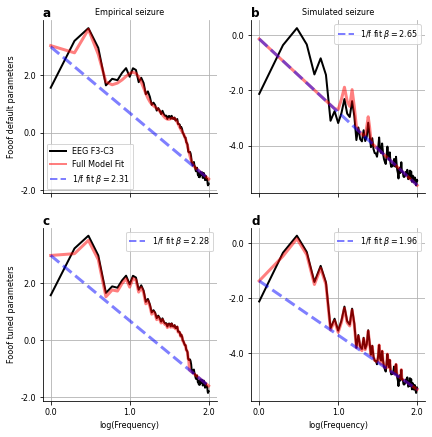

In [10]:
fig, axes = plt.subplots(2, 2,  figsize=[fig_width, 7], sharex=True)

ax = axes[0, 0]

fm_emp.plot(plt_log=True, ax=ax)
ax.set_ylabel("Fooof default parameters", fontsize=legend_fontsize)
ax.set_title("Empirical seizure", fontsize=legend_fontsize)
ax.set_xlabel("")
yticks = ax.get_yticks()
ax.set_yticklabels(yticks, fontsize=legend_fontsize)
handles, labels = ax.get_legend_handles_labels()
labels[0] = "EEG F3-C3"
labels[-1] = fr"1/f fit $\beta=${fm_emp.aperiodic_params_[1]:.2f}"
leg = ax.legend(handles, labels, fontsize=legend_fontsize)
for handle in leg.legendHandles:
    handle.set_linewidth(2)
ax.text(s="a", **panel_labels, transform=ax.transAxes)

ax = axes[0, 1]

fm_sim.plot(plt_log=True, ax=ax)
ax.set_title("Simulated seizure", fontsize=legend_fontsize)
ax.set_ylabel("")
ax.set_xlabel("")
yticks = ax.get_yticks()
ax.set_yticklabels(yticks, fontsize=legend_fontsize)
handles, labels = ax.get_legend_handles_labels()
labels[-1] = fr"1/f fit $\beta=${fm_sim.aperiodic_params_[1]:.2f}"
leg = ax.legend(handles[-1:], labels[-1:], fontsize=legend_fontsize)
for handle in leg.legendHandles:
    handle.set_linewidth(2)
ax.text(s="b", **panel_labels, transform=ax.transAxes)

ax = axes[1, 0]

fm_emp_tuned.plot(plt_log=True, ax=ax)
ax.set_ylabel("Fooof tuned parameters", fontsize=legend_fontsize)
handles, labels = ax.get_legend_handles_labels()
labels[-1] = fr"1/f fit $\beta=${fm_emp_tuned.aperiodic_params_[1]:.2f}"
leg = ax.legend(handles[-1:], labels[-1:], fontsize=legend_fontsize)
for handle in leg.legendHandles:
    handle.set_linewidth(2)
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticklabels(xticks, fontsize=legend_fontsize)
ax.set_yticklabels(yticks, fontsize=legend_fontsize)
ax.set_xlabel("log(Frequency)", fontsize=legend_fontsize)
ax.text(s="c", **panel_labels, transform=ax.transAxes)

ax = axes[1, 1]

fm_sim_tuned.plot(plt_log=True, ax=ax)
ax.set_xlabel("log(Frequency)", fontsize=legend_fontsize)
ax.set_ylabel("")
xticks = ax.get_xticks()
ax.set_xticklabels(xticks, fontsize=legend_fontsize)
yticks = ax.get_yticks()
ax.set_yticklabels(yticks, fontsize=legend_fontsize)
handles, labels = ax.get_legend_handles_labels()
labels[-1] = fr"1/f fit $\beta=${fm_sim_tuned.aperiodic_params_[1]:.2f}"
leg = ax.legend(handles[-1:], labels[-1:], fontsize=legend_fontsize)
for handle in leg.legendHandles:
    handle.set_linewidth(2)
ax.text(s="d", **panel_labels, transform=ax.transAxes)

plt.savefig(fig_path + "Fig4_SuppMat.pdf", bbox_inches="tight")
plt.savefig(fig_path + "Fig4_SuppMat.png", dpi=1000,
            bbox_inches="tight")